In [1]:
import sys
sys.path.append("..")
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from earlyrnn import EarlyRNN
import torch
from tqdm import tqdm
from loss import EarlyRewardLoss
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict
from utils.helpers_training import parse_args, train_epoch, test_epoch
from utils.metrics import harmonic_mean_score
import matplotlib.pyplot as plt
from models.model_helpers import count_parameters


In [2]:
data_path = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
dataset = "breizhcrops"
sequence_length = 150
dataroot = os.path.join(data_path,"breizhcrops")
nclasses = 9
input_dim = 13
print("get doys dict test")
doys_dict_test = get_doys_dict_test(dataroot=os.path.join(data_path,dataset))
length_sorted_doy_dict_test = create_sorted_doys_dict_test(doys_dict_test)
print("get doys dict test done")
print("get train and validation data...")
test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=sequence_length, return_id=True)
class_names = test_ds.ds.classname
print("class names:", class_names)

get doys dict test
get doys dict test done
get train and validation data...
1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:48<00:00, 2529.29it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


In [17]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

PALETTE = sns.color_palette("colorblind")

def plot_spectral_bands(idx, fig, ax, palette=PALETTE):
    doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    X, y, id_ = test_ds[idx]  # Ensure test_ds is accessible and contains the expected data structure
    # Ensure doys_dict_test and class_names are accessible and contain the expected data structures
    for band_idx, band_data in enumerate(X.T):  # Assuming X is structured with bands along columns
        ax.plot(doys_dict_test[id_], band_data[:len(doys_dict_test[id_])], color=palette[band_idx % len(palette)])
    
    ax.legend(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12',
               'QA10', 'QA20', 'QA60', 'doa'])
    ax.grid()
    ax.set_xticks(doys_months)
    ax.set_xticklabels(months, ha="left")
    ax.set_xlabel("Day of year")
    print(f"Sample {id_} has label {class_names[y[0]]}")  # Ensure class_names is accessible
    fig.tight_layout()
    return fig, ax


Sample 6032441 has label permanent meadows


(<Figure size 1500x700 with 1 Axes>, <Axes: xlabel='Day of year'>)

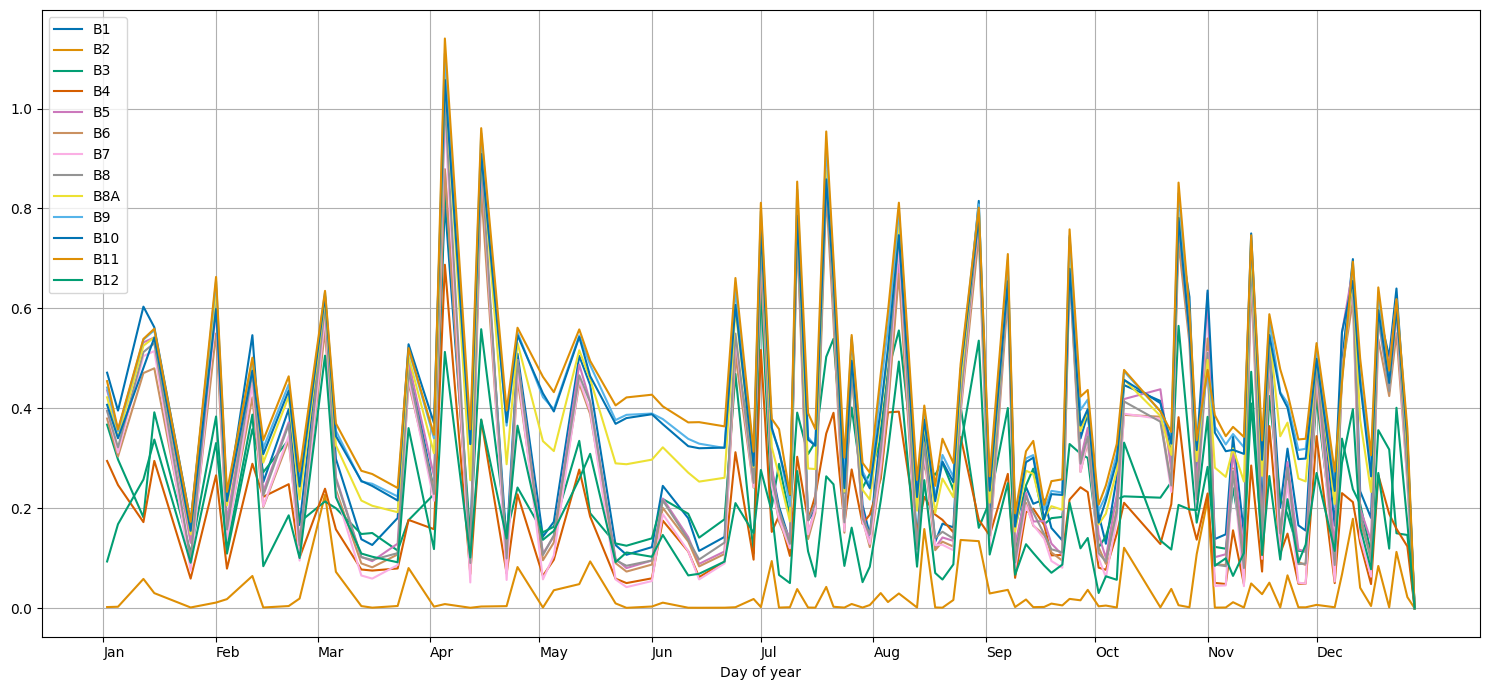

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
idx = 11498
plot_spectral_bands(idx, fig, ax)


Sample 6032238 has label corn


(<Figure size 1500x700 with 1 Axes>, <Axes: xlabel='Day of year'>)

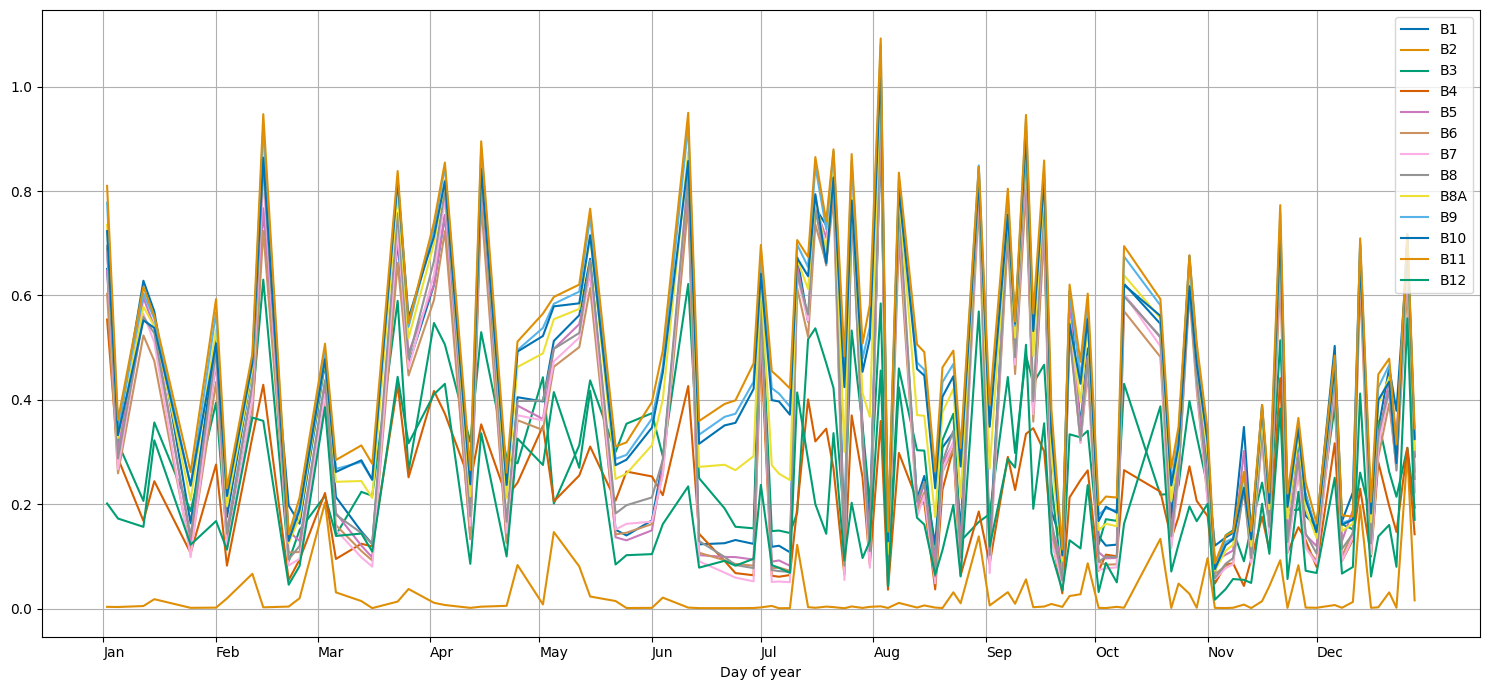

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
idx = 11345
plot_spectral_bands(idx, fig, ax)

## Count number of parcels per dataset

In [3]:
print("test_ds length:", len(test_ds))

test_ds length: 122614


In [4]:
train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=sequence_length, return_id=True)
print("train_ds length:", len(train_ds))

2559635960 2559635960


loading data into RAM: 100%|██████████| 178613/178613 [01:11<00:00, 2513.24it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 140645/140645 [00:58<00:00, 2419.76it/s]

train_ds length: 319258


In [5]:
valid_ds = BreizhCrops(root=dataroot,partition="valid", sequencelength=sequence_length, return_id=True)
print("valid_ds length:", len(valid_ds))

2493572704 2493572704


loading data into RAM: 100%|██████████| 166391/166391 [01:07<00:00, 2458.00it/s]

valid_ds length: 166391


In [6]:
# sum of all the samples:
print("sum of all samples:", len(train_ds)+len(valid_ds)+len(test_ds))

sum of all samples: 608263
